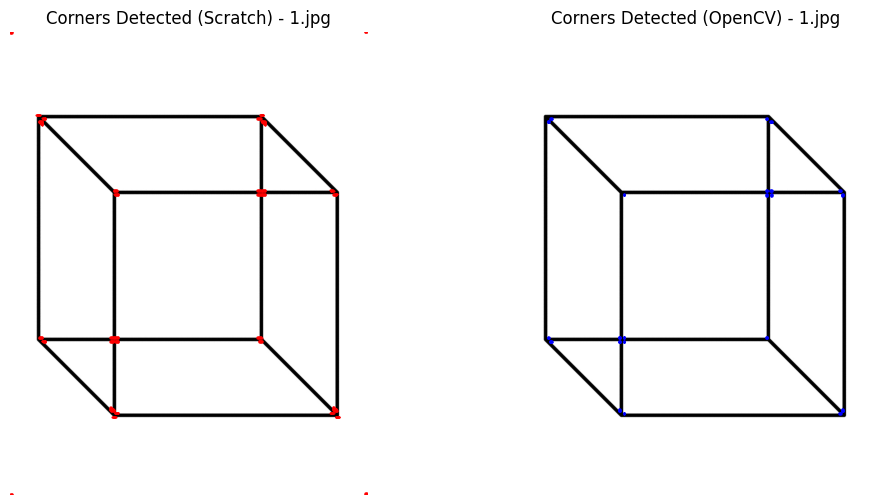

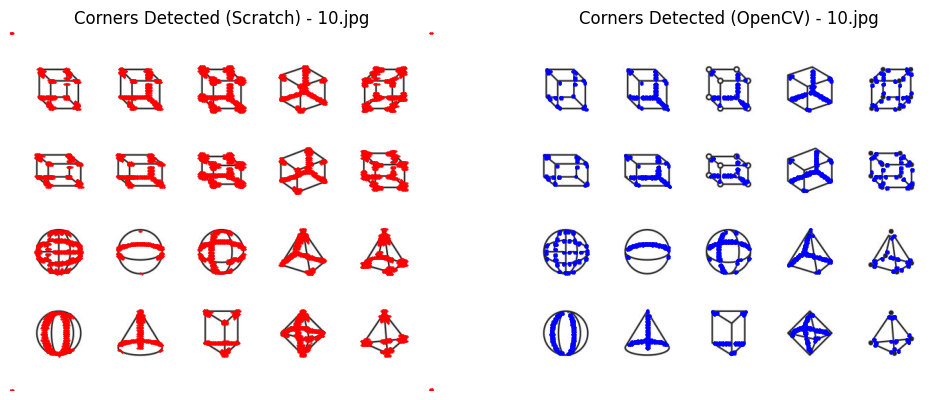

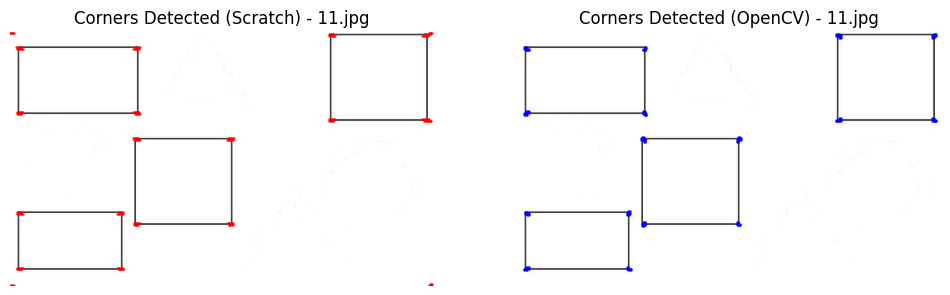

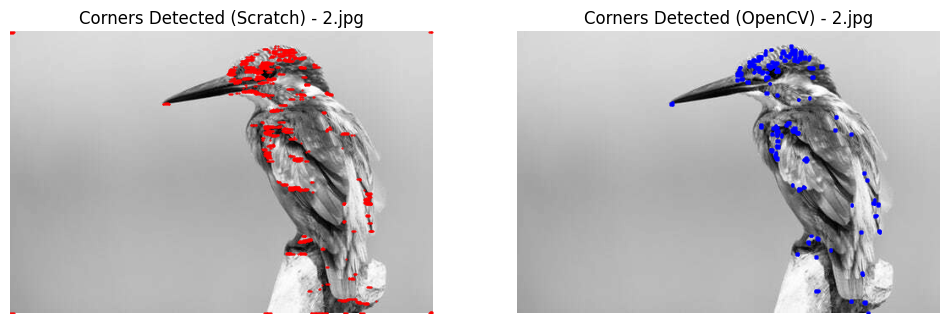

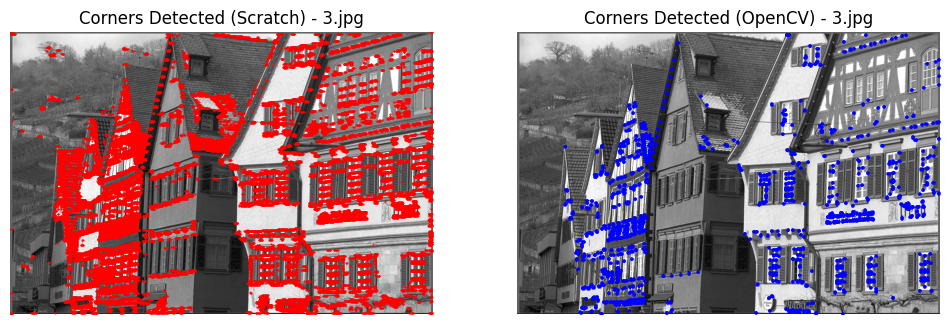

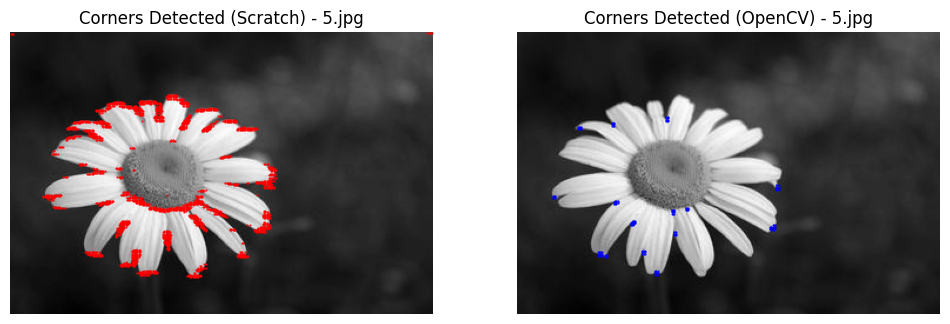

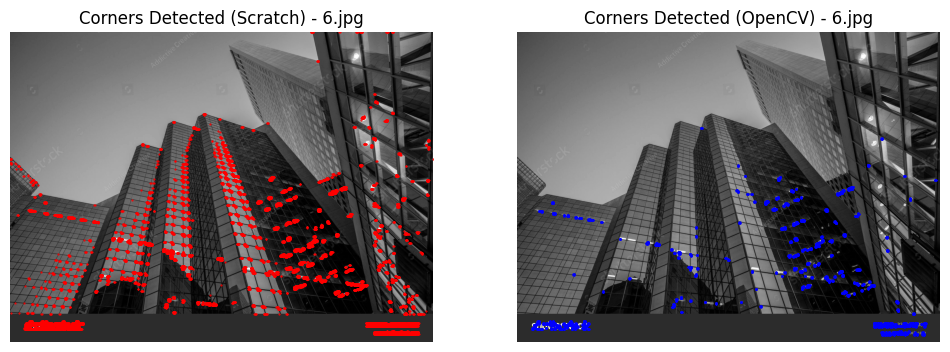

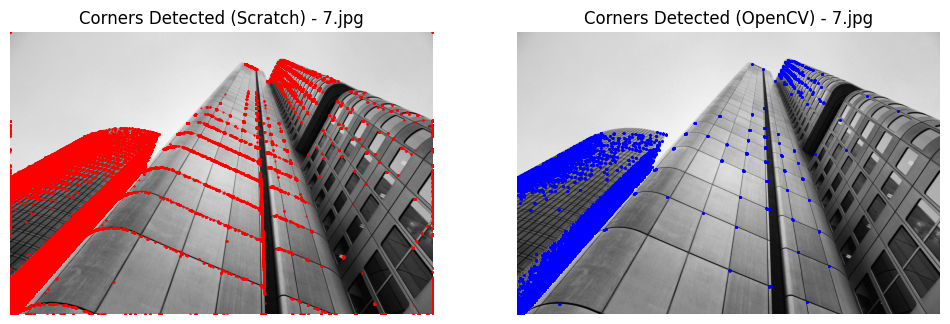

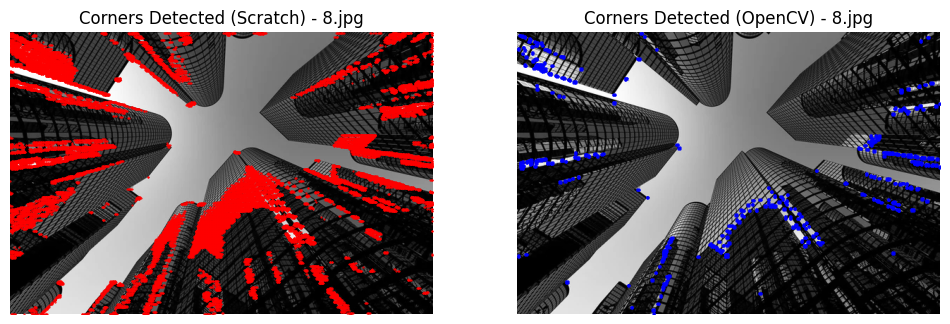

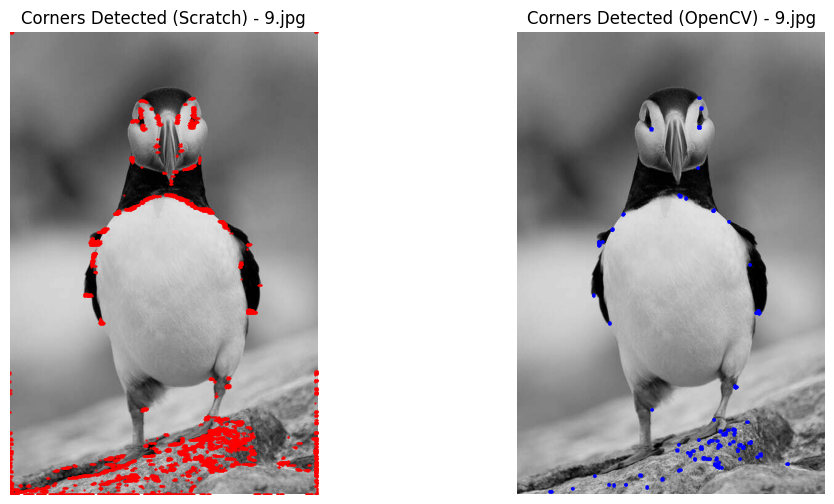

In [32]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def filter2D(image, kernel):
    # Ensure the kernel has odd dimensions
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1, "Kernel dimensions must be odd"
    
    # Pad the image with zeros to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant')
    
    # Compute convolution
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            filtered_image[i, j] = np.sum(patch * kernel)
    
    return filtered_image

def gaussian_blur(image, kernel_size=3, sigma=1.0):
    # Create Gaussian kernel
    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    kernel = np.exp(-0.5 * (np.square(x - kernel_size // 2) + np.square(y - kernel_size // 2)) / (sigma ** 2))
    kernel /= np.sum(kernel)  # Normalize the kernel
    
    # Apply convolution
    blurred_image = np.convolve(image.ravel(), kernel.ravel(), mode='same').reshape(image.shape)
    
    return blurred_image

def sobel_operator(image):
    # Define Sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Compute gradients
    #gradient_x = np.convolve(image.ravel(), kernel_x.ravel(), mode='same').reshape(image.shape)
    #gradient_y = np.convolve(image.ravel(), kernel_y.ravel(), mode='same').reshape(image.shape)
    gradient_x=filter2D(image,kernel_x)
    gradient_y=filter2D(image,kernel_y)
    
    return gradient_x, gradient_y

def process_images_in_folder(folder_path):
    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Consider only image files
            # Read image using cv2
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Convert image to floating point
            image = image.astype(np.float64)

            # Step 1: Compute image gradients over a small region
            Ix, Iy = sobel_operator(image)

            # Step 2: Subtract mean from each image gradient
            Ix_mean = np.mean(Ix)
            Iy_mean = np.mean(Iy)
            Ix -= Ix_mean
            Iy -= Iy_mean

            # Step 3: Compute the covariance matrix
            IxIx = Ix * Ix
            IxIy = Ix * Iy
            IyIy = Iy * Iy
            IxIx_blurred = gaussian_blur(IxIx)
            IxIy_blurred = gaussian_blur(IxIy)
            IyIy_blurred = gaussian_blur(IyIy)

            # Step 4: Compute response using Harris corner detector
            k = 0.001
            det = IxIx_blurred * IyIy_blurred - IxIy_blurred * IxIy_blurred
            trace = IxIx_blurred + IyIy_blurred
            #response = det / (trace + k)
            response =det-k*(trace*trace)

            # Step 5: Use threshold on response to detect corners
            threshold = 0.01 * np.max(response)
            corners_scratch = np.argwhere(response > threshold)

            # Detect corners using cv2.cornerHarris
            corners_opencv = cv2.cornerHarris(np.uint8(image), 2, 3, 0.094)
            corners_opencv = cv2.dilate(corners_opencv, None)
            corners_opencv = np.argwhere(corners_opencv > 0.1 * corners_opencv.max())

            # Plot corners for scratch method and cv2.cornerHarris side by side
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            axes[0].imshow(image, cmap='gray')
            axes[0].plot(corners_scratch[:, 1], corners_scratch[:, 0], 'ro', markersize=0.5)
            axes[0].set_title(f'Corners Detected (Scratch) - {filename}')
            axes[0].axis('off')

            axes[1].imshow(image, cmap='gray')
            axes[1].plot(corners_opencv[:, 1], corners_opencv[:, 0], 'bo', markersize=0.5)
            axes[1].set_title(f'Corners Detected (OpenCV) - {filename}')
            axes[1].axis('off')

            plt.show()

# Specify the folder containing images
folder_path = 'D:\\M.Tech\\M.Tech Sem2\\Computer Vision\\Assignment 1\\Assignment 1 Input Images\\Question 1'

# Process images in the folder
process_images_in_folder(folder_path)